In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import roc_curve, auc

In [2]:
df = pd.read_csv('Final_version_cleaned.csv')

df = df.dropna()

# Define target variable and features
X = df.drop('isDefault', axis=1)  # Replace 'target_column' with your actual target column name
y = df['isDefault']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [3]:
# Initialize the models
gbm = GradientBoostingClassifier(random_state=42)
sgd_clf = SGDClassifier(loss='log', max_iter=1000, tol=1e-3, random_state=42)

# Train GBM
gbm.fit(X_train, y_train)
print("GBM training complete.")

# Train SGDClassifier 
sgd_clf.fit(X_train, y_train)
print("SGDClassifier training complete.")

GBM training complete.


/Users/amariparris/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


SGDClassifier training complete.


/Users/amariparris/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


In [5]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Cross-validated predictions for GBM
gbm_cv_preds = cross_val_predict(gbm, X_train, y_train, cv=kf, method="predict_proba")[:, 1]

# Cross-validated predictions for SGDC
sgd_cv_preds = cross_val_predict(sgd_clf, X_train, y_train, cv=kf, method="predict_proba")[:, 1]

# Combine predictions into a new dataset for training the meta-model
X_meta_train = np.column_stack((gbm_cv_preds, sgd_cv_preds))

/Users/amariparris/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/Users/amariparris/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/Users/amariparris/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/amariparris/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivale

In [6]:
from sklearn.linear_model import LogisticRegression

# Initialize log regression model
log = LogisticRegression(random_state=42)

# Train log regression
log.fit(X_meta_train, y_train)

print("Log regression ensemble model training complete.")

Log regression ensemble model training complete.


In [8]:
# Generate predictions for test set
gbm_test_preds = gbm.predict_proba(X_test)[:, 1]
sgd_test_preds = sgd_clf.predict_proba(X_test)[:, 1]

# Combine predictions to create a new test dataset for the meta-model
X_meta_test = np.column_stack((gbm_test_preds, sgd_test_preds))

In [9]:
# Make final predictions using log regression ensemble model 
final_predictions = log.predict(X_meta_test)

# Calculate the probabilities of the positive class
probabilities = log.predict_proba(X_meta_test)[:, 1]


# Evaluate ensemble model
accuracy = accuracy_score(y_test, final_predictions)
roc_auc = roc_auc_score(y_test, probabilities)

print(f"Ensemble Model Accuracy: {accuracy}")
print(f"Ensemble Model ROC AUC: {roc_auc}")

Ensemble Model Accuracy: 0.80458125
Ensemble Model ROC AUC: 0.7249136913070783


In [12]:
# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, probabilities)
roc_auc = auc(fpr, tpr)

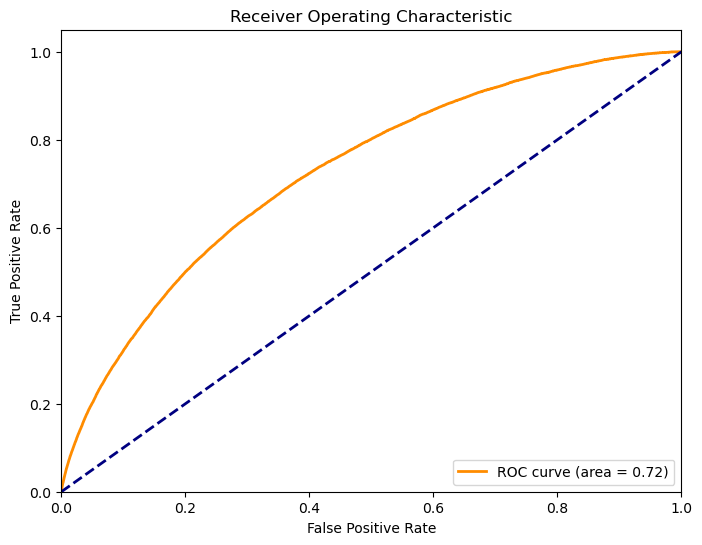

In [13]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()